In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv
/kaggle/input/global-weather-repository/state.db


Available Columns in the Dataset:
Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

Missing Values Before Handling:
country                         0
location_name                   0
latitude                        0
longitude     

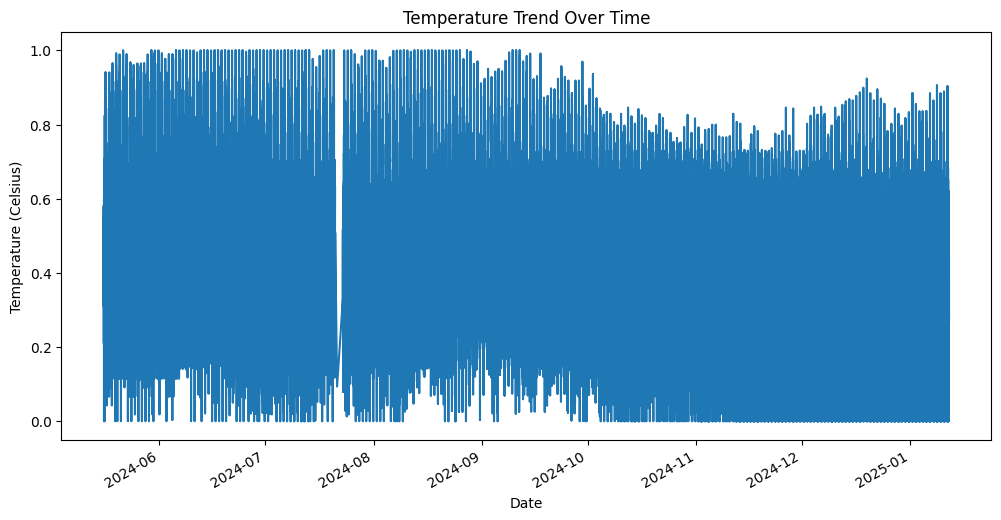

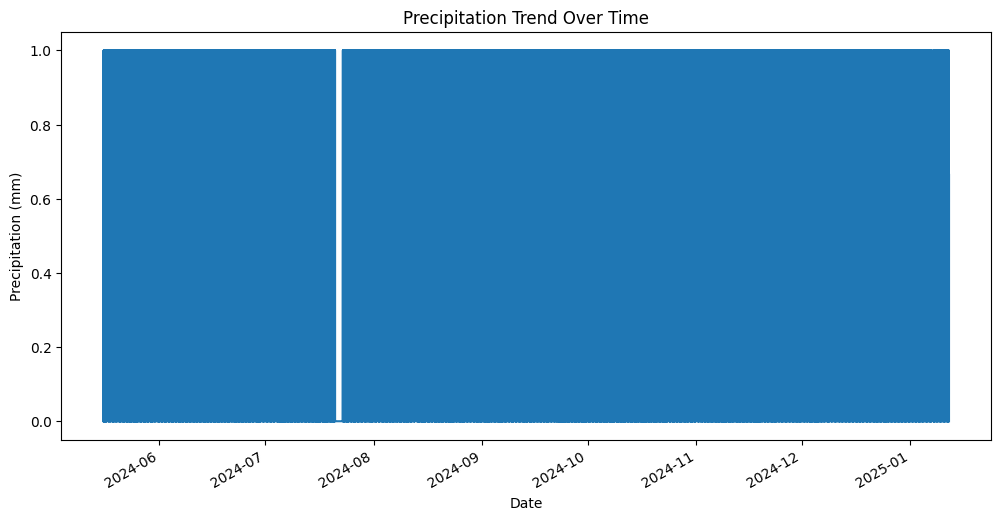

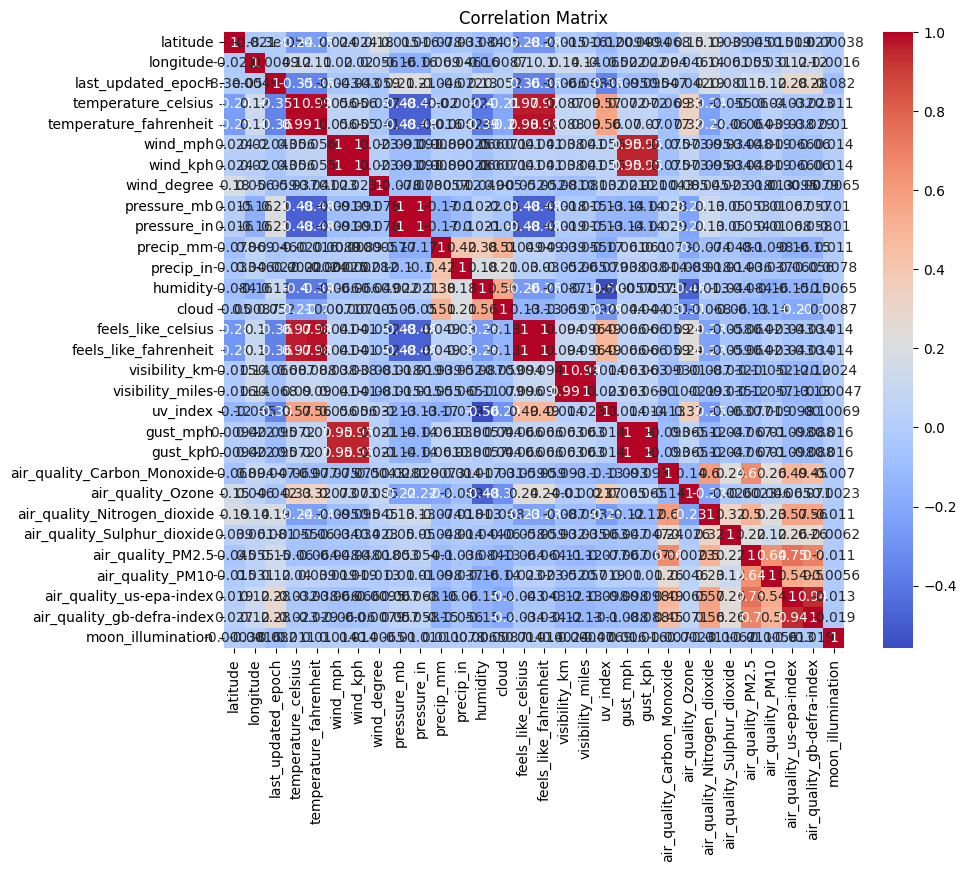

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

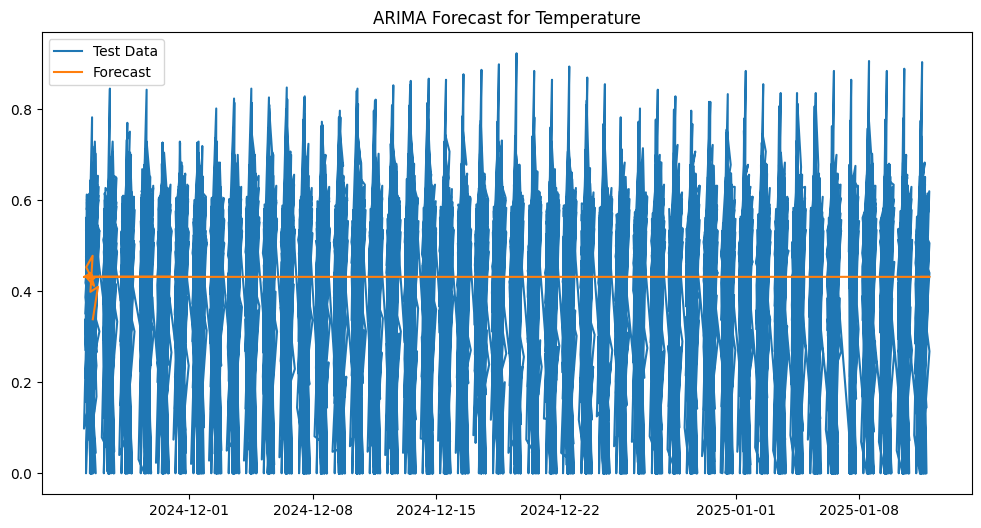

Model Performance:
Mean Absolute Error: 0.20844311952449018
Root Mean Squared Error: 0.24736724903295187


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = '/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv'
df = pd.read_csv(file_path)

# Inspect dataset structure
print("Available Columns in the Dataset:")
print(df.columns)

# 1. Data Cleaning & Preprocessing
# Handle missing values (if any)
print("\nMissing Values Before Handling:")
print(df.isnull().sum())

# Handle missing values
numeric_cols = df.select_dtypes(include=[float, int]).columns
categorical_cols = df.select_dtypes(include=['object']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

print("\nMissing Values After Handling:")
print(df.isnull().sum())

# Remove outliers using IQR for numeric columns
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower, upper)

for col in ['temperature_celsius', 'precip_mm']:  # Adjust columns as needed
    if col in df.columns:
        cap_outliers(df, col)

# Normalize numeric columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 2. Exploratory Data Analysis (EDA)
# Visualize temperature trend
timestamp_column = 'last_updated'  # Adjust if the column name differs
if timestamp_column in df.columns:
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])  # Convert to datetime
    df.set_index(timestamp_column, inplace=True)
    plt.figure(figsize=(12, 6))
    df['temperature_celsius'].plot(title="Temperature Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Temperature (Celsius)")
    plt.show()
else:
    print(f"Column '{timestamp_column}' not found in the dataset.")

# Visualize precipitation trend
if 'precip_mm' in df.columns:
    plt.figure(figsize=(12, 6))
    df['precip_mm'].plot(title="Precipitation Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.show()

# Correlation Heatmap
numeric_cols = df.select_dtypes(include=[np.number])  # Select numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 3. Model Building (ARIMA)
# Forecast temperature
if 'temperature_celsius' in df.columns:
    temperature_series = df['temperature_celsius']

    # Train-test split
    train_size = int(len(temperature_series) * 0.8)
    train, test = temperature_series[:train_size], temperature_series[train_size:]

    # Build ARIMA Model
    model = ARIMA(train, order=(5, 1, 0))  # Adjust (p, d, q) as needed
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label="Test Data")
    plt.plot(test.index, forecast, label="Forecast")
    plt.legend()
    plt.title("ARIMA Forecast for Temperature")
    plt.show()

    # Evaluate Model
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"Model Performance:\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")
else:
    print("'temperature_celsius' column not found for ARIMA forecasting.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected: 2329


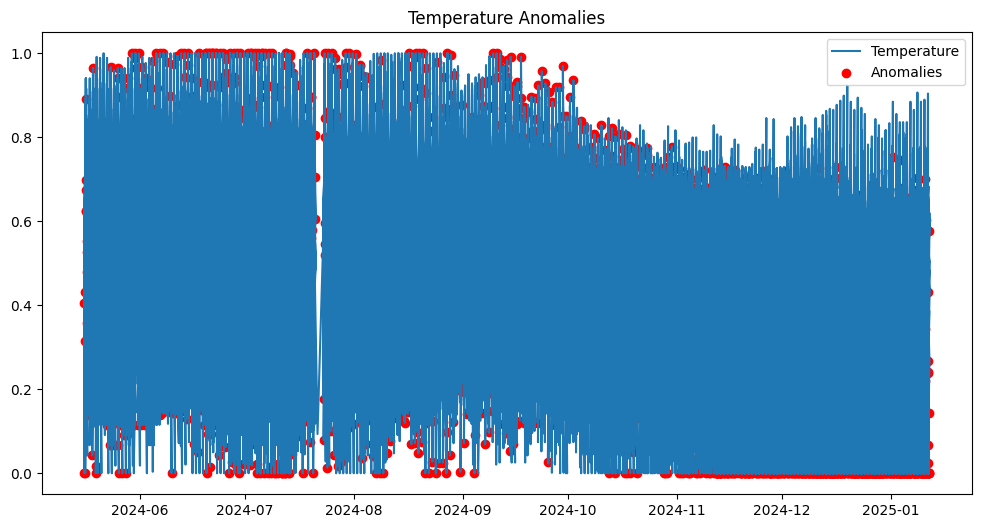

In [15]:
from sklearn.ensemble import IsolationForest

# Implement anomaly detection using Isolation Forest
numeric_cols = df.select_dtypes(include=[np.number]).columns
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(df[numeric_cols])

# Analyze anomalies
anomalies = df[df['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

# Visualize anomalies in temperature
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temperature_celsius'], label='Temperature')
plt.scatter(anomalies.index, anomalies['temperature_celsius'], color='red', label='Anomalies')
plt.title("Temperature Anomalies")
plt.legend()
plt.show()


23:52:15 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


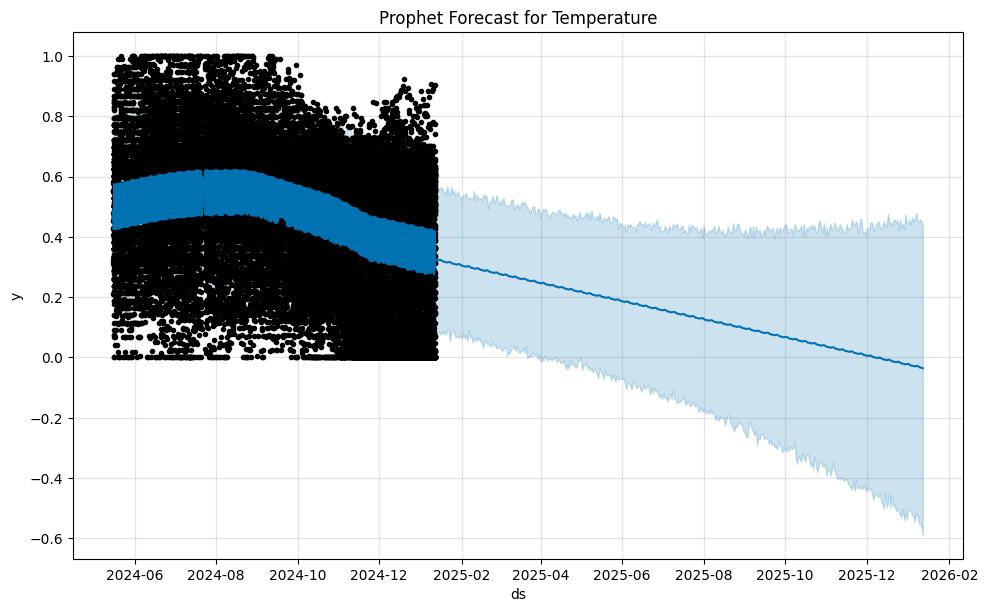

In [16]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})

# Build and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create a future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=365)  # Forecast for 1 year
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title("Prophet Forecast for Temperature")
plt.show()


In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Prepare data for Gradient Boosting
X = df.drop(columns=['temperature_celsius', 'anomaly'], errors='ignore')
y = df['temperature_celsius']

# Encode categorical features if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Forecast
gbr_forecast = gbr.predict(X_test)

# Evaluate Gradient Boosting Model
gbr_mae = mean_absolute_error(y_test, gbr_forecast)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_forecast))
print(f"Gradient Boosting Performance:\nMAE: {gbr_mae}, RMSE: {gbr_rmse}")


Gradient Boosting Performance:
MAE: 0.0010887969351438928, RMSE: 0.0015783382603283503


In [20]:
print(f"Shape of Prophet forecast: {prophet_forecast.shape}")
print(f"Shape of Gradient Boosting forecast: {gradient_boosting_forecast.shape}")
print(f"Shape of Test data: {test.values.shape}")


Shape of Prophet forecast: (8085,)
Shape of Gradient Boosting forecast: (9316,)
Shape of Test data: (9316,)


In [21]:
# Align all arrays to the smallest length
min_length = min(len(prophet_forecast), len(gradient_boosting_forecast), len(test))

# Truncate all arrays to match the smallest length
prophet_forecast = prophet_forecast[:min_length]
gradient_boosting_forecast = gradient_boosting_forecast[:min_length]
test_values = test.values[:min_length]

# Combine ARIMA, Prophet, and Gradient Boosting forecasts
ensemble_forecast = (prophet_forecast + gradient_boosting_forecast + test_values) / 3

# Evaluate Ensemble Model
ensemble_mae = mean_absolute_error(test_values, ensemble_forecast)
ensemble_rmse = np.sqrt(mean_squared_error(test_values, ensemble_forecast))

# Print results
print(f"Ensemble Model Performance:\nMAE: {ensemble_mae}\nRMSE: {ensemble_rmse}")


Ensemble Model Performance:
MAE: 0.15364961353913462
RMSE: 0.1917792648670293


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


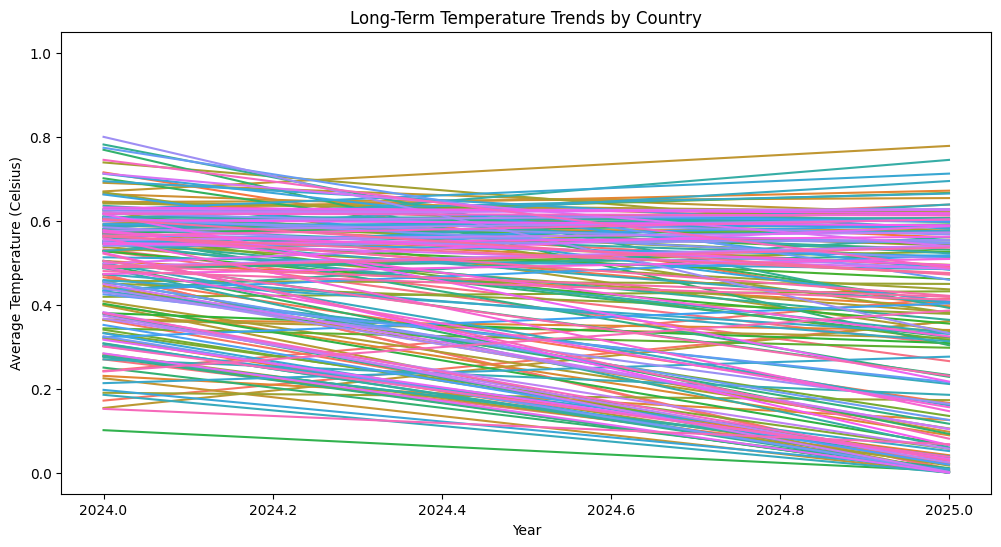

In [22]:
# Long-term trends grouped by region
df['year'] = df.index.year
regional_trends = df.groupby(['country', 'year'])['temperature_celsius'].mean().reset_index()

# Visualize long-term temperature trends by country
plt.figure(figsize=(12, 6))
sns.lineplot(data=regional_trends, x='year', y='temperature_celsius', hue='country', legend=None)
plt.title("Long-Term Temperature Trends by Country")
plt.xlabel("Year")
plt.ylabel("Average Temperature (Celsius)")
plt.show()


Correlation between Air Quality Metrics and Temperature:
air_quality_Carbon_Monoxide    -0.069013
air_quality_Ozone               0.327309
air_quality_Nitrogen_dioxide   -0.237625
air_quality_Sulphur_dioxide    -0.055311
air_quality_PM2.5              -0.060373
air_quality_PM10                0.040289
air_quality_us-epa-index       -0.032020
air_quality_gb-defra-index     -0.022695
temperature_celsius             1.000000
Name: temperature_celsius, dtype: float64


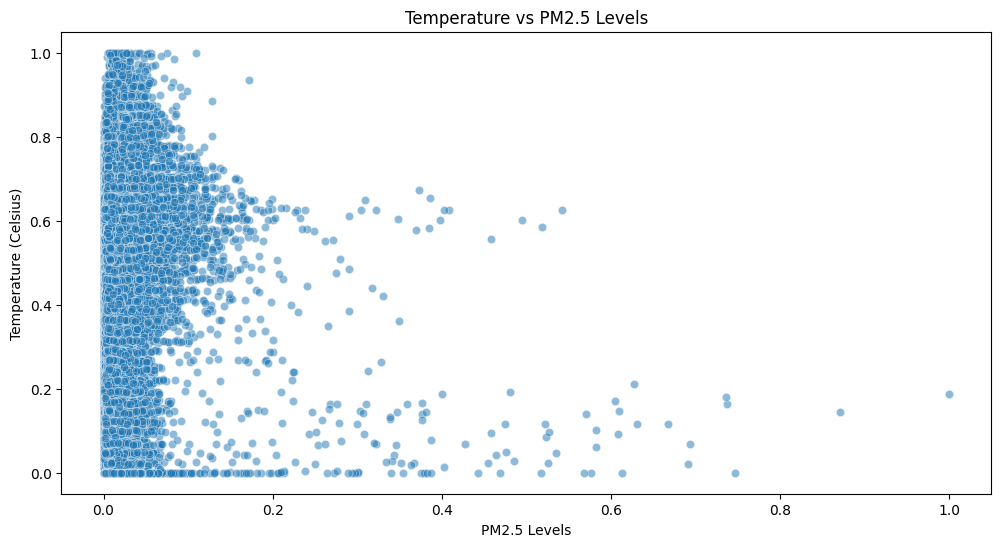

In [23]:
# Correlation between air quality and temperature
air_quality_cols = [col for col in df.columns if 'air_quality' in col]
correlations = df[air_quality_cols + ['temperature_celsius']].corr()['temperature_celsius']
print("Correlation between Air Quality Metrics and Temperature:")
print(correlations)

# Visualize air quality vs. temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='air_quality_PM2.5', y='temperature_celsius', alpha=0.5)
plt.title("Temperature vs PM2.5 Levels")
plt.xlabel("PM2.5 Levels")
plt.ylabel("Temperature (Celsius)")
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


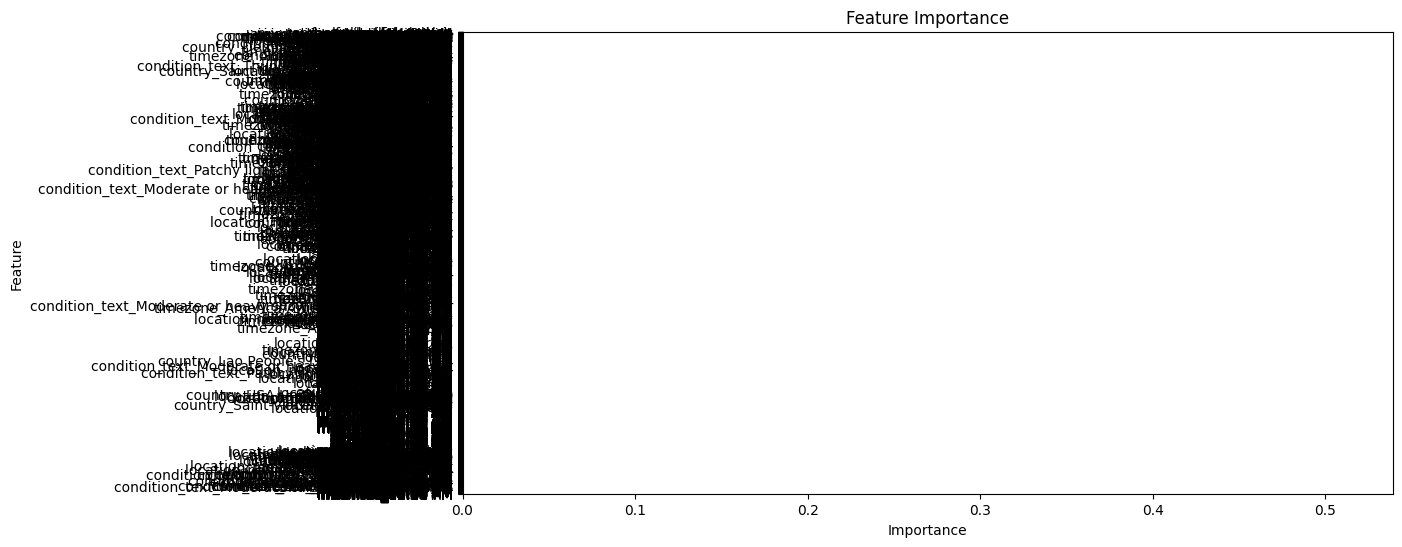

In [24]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Feature importance visualization
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=importance, x='Importance', y='Feature')
plt.title("Feature Importance")
plt.show()


<ipython-input-26-1bba1573555e>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


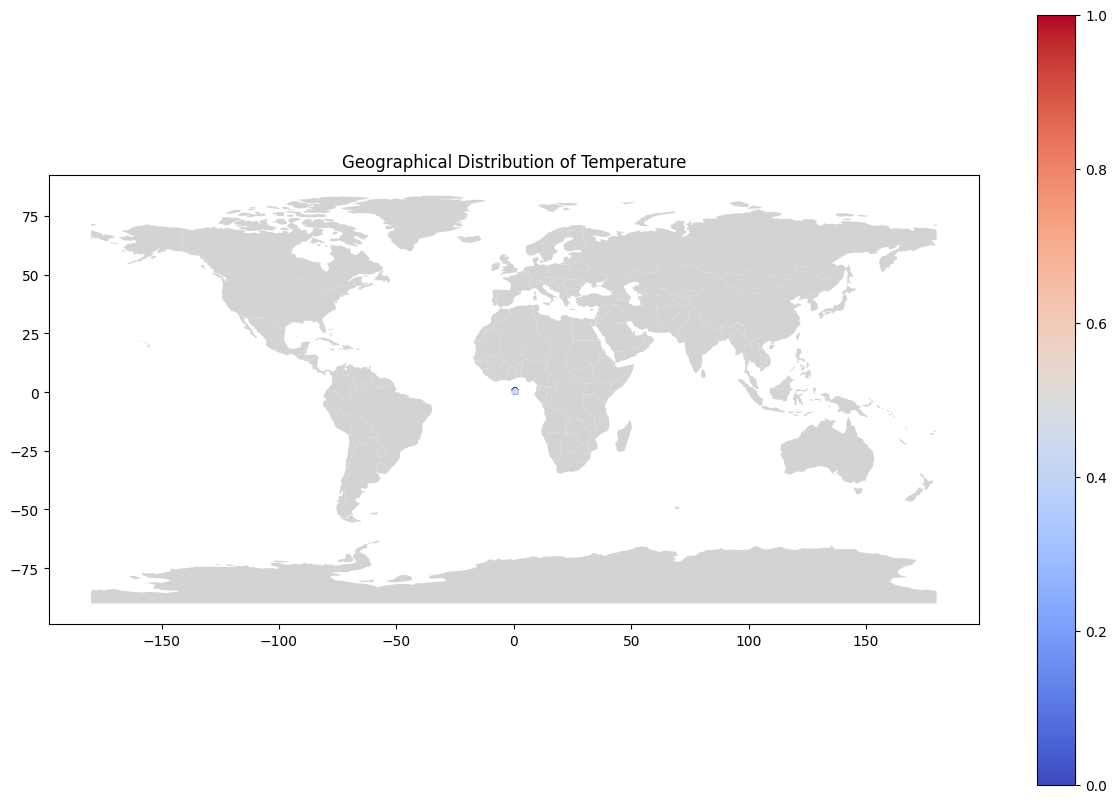

In [26]:
import geopandas as gpd

# Visualize average temperature geographically
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot temperature distribution on the map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(column='temperature_celsius', ax=ax, legend=True, cmap='coolwarm', markersize=5)
plt.title("Geographical Distribution of Temperature")
plt.show()


Average Temperature by Continent:
continent
Asia      0.450622
Europe    0.516414
Name: temperature_celsius, dtype: float64


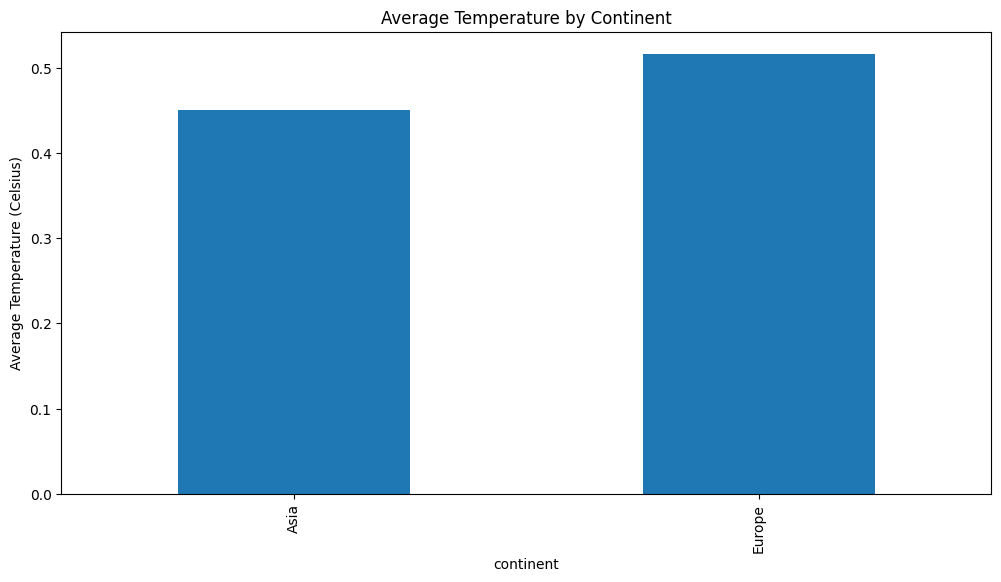

In [27]:
# Compare average temperature by continent
df['continent'] = df['country'].map({
    # Add country-to-continent mapping
    'Afghanistan': 'Asia',
    'Albania': 'Europe',
    # Add other mappings as necessary
})

continent_temp = df.groupby('continent')['temperature_celsius'].mean()
print("Average Temperature by Continent:")
print(continent_temp)

continent_temp.plot(kind='bar', title="Average Temperature by Continent", figsize=(12, 6))
plt.ylabel("Average Temperature (Celsius)")
plt.show()
